In [1]:
# Autoencoder Latent space 2 cells real data WATER

# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>

Training : Synthetic Data <br>
Testing  : Real Data <br>
MAE

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages = 3 

In [3]:
def label_marker(row):
    if isinstance(row[label_name], str) and 'Natural' in row[label_name]:
        return 0
    if isinstance(row[label_name], str) and 'Attack' in row[label_name]:
        return 1
    return 

In [4]:
path = './water/'
label_name = "'result'"
path_figures = './figures/'

#path_normal = path +'VAE_syntheticdata_normal_epoch100_1000000.csv'
path_normal = path +'Water_Normal.csv'
path_attack = path + 'Water_Attack.csv' # real data

normal_df = pd.read_csv(path_normal)  
attack_df = pd.read_csv(path_attack)  

normal_df[label_name] = normal_df.apply(label_marker, axis=1)
attack_df[label_name] = attack_df.apply(label_marker, axis=1)

normal_label = normal_df[label_name].to_numpy() 
attack_label = attack_df[label_name].to_numpy() 

print(len(normal_label))
print(len(attack_label))

172415
63764


In [5]:
# Delete marker column 
normal_df.drop([label_name], axis=1, inplace=True)
attack_df.drop([label_name], axis=1, inplace=True)

In [6]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
normal_np = normal_df.to_numpy()
print('normal shape',normal_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (172415, 23)
attack shape (63764, 23)


In [7]:

normal_df = normal_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
normal_scaled = scaler.fit_transform(normal_df)

attack_df = attack_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
attack_scaled = scaler.fit_transform(attack_df)

In [8]:
norm_samples = normal_scaled
attack_samples = attack_scaled
print (attack_samples.shape)
print (norm_samples.shape)

(63764, 23)
(172415, 23)


In [9]:
# generate train set
# training set will consist of the normal ds

len_norm = len(norm_samples)
len_norm_train = int(0.80 * len_norm)
X_train = norm_samples[:len_norm_train]

# generate test set consist of 50% attack and 50% normal

X_test_norm = norm_samples[len_norm_train:]
len_attack_test = len(X_test_norm) # we will use the same number
X_test_attack = attack_scaled[:len_attack_test]

X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [10]:
#x_train = traffic_np_norm[...,np.newaxis]
#x_combine = combine_np_norm[...,np.newaxis]
#x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", X_train.shape)
print("Combine Traffic Test input shape: ", X_test.shape)

Normal Traffic Training input shape:  (137932, 23)
Combine Traffic Test input shape:  (68966, 23)


In [11]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]

print(input_dim)
latent_space = 2

dr = 0.15
input_ANN = layers.Input(shape=(input_dim, ))
encoder = layers.Dense(23, activation='relu')(input_ANN)
encoder = layers.Dropout(rate=dr)(encoder)
encoder = layers.Dense(16, activation='relu')(encoder)
encoder = layers.Dropout(rate=dr)(encoder)
encoder = layers.Dense(8, activation='relu')(encoder)
encoder = layers.Dropout(rate=dr)(encoder)
encoder = layers.Dense(4, activation='relu')(encoder)
encoder = layers.Dropout(rate=dr)(encoder)
encoder = layers.Dense(2, activation='relu')(encoder)

decoder = layers.Dense(4, activation='relu')(encoder)
decoder = layers.Dropout(rate=dr)(decoder)
decoder = layers.Dense(8, activation='relu')(decoder)
decoder = layers.Dropout(rate=dr)(decoder)
decoder = layers.Dense(16, activation='relu')(decoder)
decoder = layers.Dropout(rate=dr)(decoder)
decoder = layers.Dense(23, activation='relu')(decoder)
decoder = layers.Dropout(rate=dr)(decoder)
out_layer = layers.Dense(encoding_dim, activation = 'sigmoid')(decoder)
autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)


23


In [12]:
# x_train = np.squeeze(X_train)
x_attack = np.squeeze(X_test)

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 23)                552       
                                                                 
 dropout (Dropout)           (None, 23)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                384       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0     

In [13]:
#noise.shape

In [14]:
## Train the model

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.17,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Train on 114483 samples, validate on 23449 samples
Epoch 1/50
112384/114483 [============================>.] - ETA: 0s - loss: 0.0390

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


114483/114483 [==============================] - 2s 18us/sample - loss: 0.0385 - val_loss: 0.0300
Epoch 2/50
114483/114483 [==============================] - 2s 14us/sample - loss: 0.0125 - val_loss: 0.0233
Epoch 3/50
114483/114483 [==============================] - 2s 14us/sample - loss: 0.0093 - val_loss: 0.0211
Epoch 4/50
114483/114483 [==============================] - 2s 14us/sample - loss: 0.0081 - val_loss: 0.0209
Epoch 5/50
114483/114483 [==============================] - 2s 13us/sample - loss: 0.0078 - val_loss: 0.0207
Epoch 6/50
114483/114483 [==============================] - 2s 13us/sample - loss: 0.0076 - val_loss: 0.0207
Epoch 7/50
114483/114483 [==============================] - 2s 13us/sample - loss: 0.0072 - val_loss: 0.0200
Epoch 8/50
114483/114483 [==============================] - 2s 14us/sample - loss: 0.0064 - val_loss: 0.0196
Epoch 9/50
114483/114483 [==============================] - 2s 13us/sample - loss: 0.0062 - val_loss: 0.0197
Epoch 10/50
114483/114483 [===

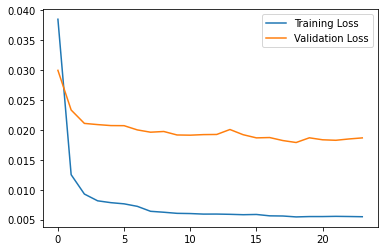

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [16]:
# we use RMSE as reconstruction error (can use MAE as well)
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [17]:
# Prediction of training vector
X_train_pred = autoencoder.predict(X_train)
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error \
      {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')

error_thresh = np.quantile(mae_vector, 0.99)
print('error threshold >>>', error_thresh)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Avg error 0.015933238704827563
median error       0.01134147579818019
99Q: 0.060928168336496065
error threshold >>> 0.060928168336496065


In [18]:
# application of error threshold in test vector
# A vector of anomalies is created with the points that go over the threshold

X_pred = autoencoder.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)
print('total length vector anomalies : ',len(anomalies))
print('Number of anomalies : ', np.count_nonzero(anomalies))
print('total length of y_test vector',len(y_test))
print('total lenght of attacks in y_test vector', np.count_nonzero(y_test))

total length vector anomalies :  68966
Number of anomalies :  35520
total length of y_test vector 68966
total lenght of attacks in y_test vector 34483


In [19]:
# Sklearn classification report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     34483
         1.0       0.97      1.00      0.99     34483

    accuracy                           0.98     68966
   macro avg       0.99      0.98      0.98     68966
weighted avg       0.99      0.98      0.98     68966



In [20]:
# we isolate encoder output this is latent space
encoder_iso = keras.Model(input_ANN, encoder)
Xpred2 = encoder_iso.predict(X_test)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [21]:
# PCA transformation to observe variance in 2 components

pca = PCA(n_components=2,random_state=124)
X_transform = pca.fit_transform(Xpred2)

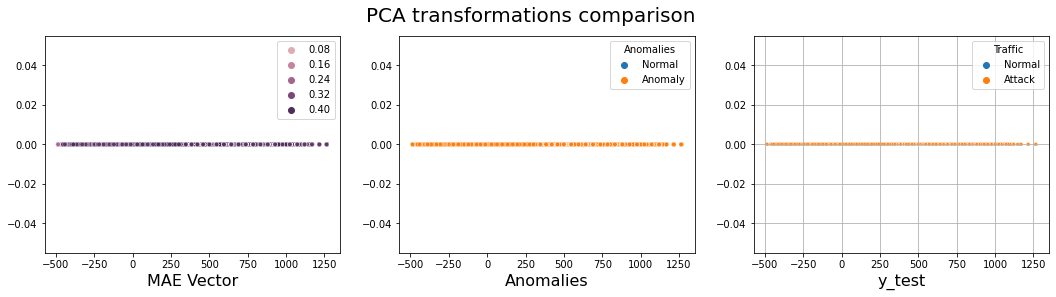

In [22]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations comparison',size=20)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies, ax=ax2)
ax2.set_xlabel('Anomalies', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Normal', 'Anomaly'], title='Anomalies')
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Normal', 'Attack'], title='Traffic')
plt.grid()
plt.show()

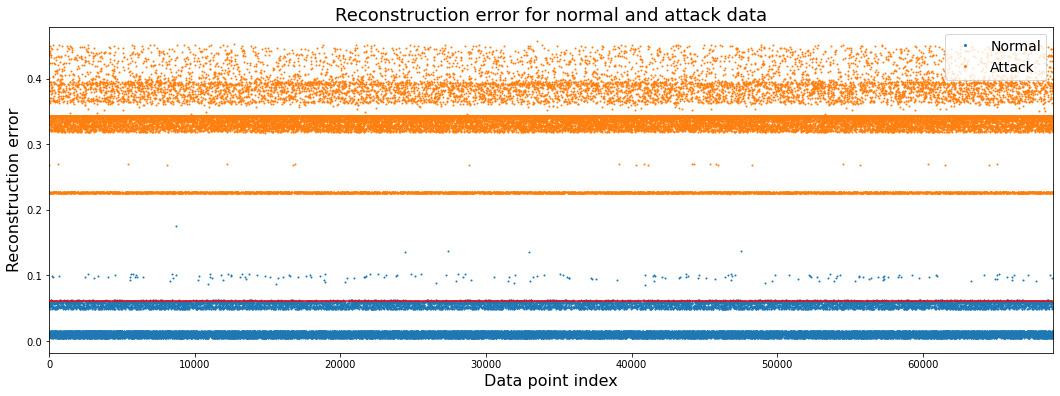

In [23]:
# Reconstruction figure
plt.rc('legend',fontsize=14)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_vector),
                        'True_class': y_test})

error_df = error_df.sample(frac=1).reset_index(drop=True)
threshold_fixed = error_thresh
groups = error_df.groupby('True_class')

fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=1, linestyle='',
            label= "Attack" if name == 1 else "Normal")

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", 
          zorder=100, label='Threshold')
plt.xlim(0,error_df.shape[0])
# leg = ax.legend()
# leg.set_title('Traffic',prop={'size':14})
legend_label, _ = ax.get_legend_handles_labels()
plt.legend(legend_label, ['Normal', 'Attack'], prop={'size': 14}, 
          loc="upper right", markerscale=2., scatterpoints=1)
plt.title("Reconstruction error for normal and attack data", size=18)
plt.ylabel("Reconstruction error", size=16)
plt.xlabel("Data point index", size = 16)
plt.show()

In [24]:
# Reconstruction errors for figure

Global_error = np.squeeze(mae_vector)
Attack_error = error_df[error_df['True_class']==1].Reconstruction_error.to_numpy()
Normal_error = error_df[error_df['True_class']==0].Reconstruction_error.to_numpy()
print(' Attack_error shape', Attack_error.shape, '\n', 
      'Normal_error shape', Normal_error.shape)

 Attack_error shape (34483,) 
 Normal_error shape (34483,)


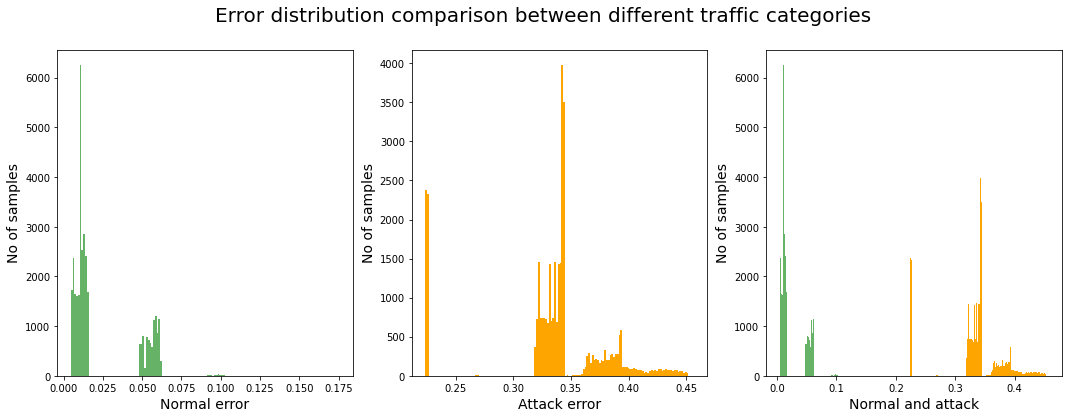

In [25]:
# Figure error distribution

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
ax2.hist(Attack_error, bins=150, color='orange')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)
ax3.hist(Attack_error, bins=150, color='orange')
ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

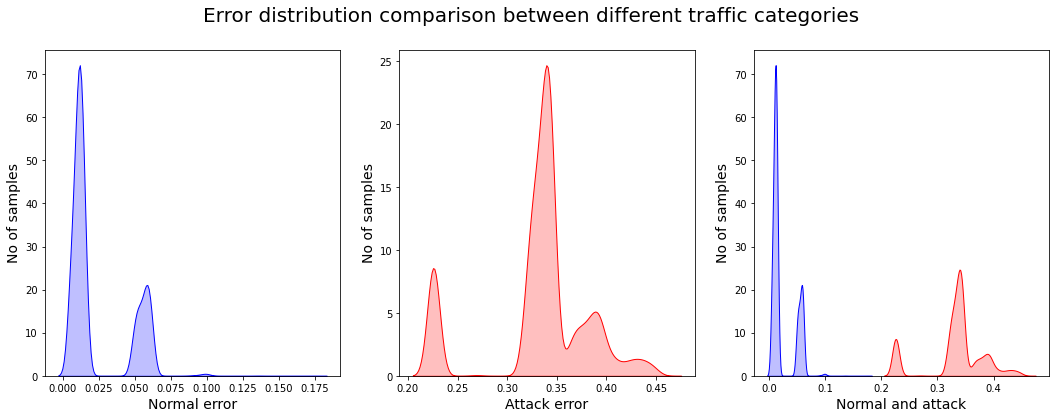

In [26]:
# Figure errors with KDE Plot

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Error distribution comparison between different traffic categories',
             size=20)
#ax1.hist(Normal_error, bins=150, color='green', alpha=0.6)

sns.kdeplot(Normal_error,fill= True, ax = ax1,color   = 'blue')

ax1.set_xlabel('Normal error', size=14)
ax1.set_ylabel('No of samples', size = 14)
sns.kdeplot(Attack_error,fill= True, ax = ax2,color = 'red')
ax2.set_xlabel('Attack error', size = 14)
ax2.set_ylabel('No of samples', size = 14)

sns.kdeplot(Normal_error,fill= True, ax = ax3,color   = 'blue')
sns.kdeplot(Attack_error,fill= True, ax = ax3,color   = 'red')
#ax3.hist(Attack_error, bins=150, color='orange')
#ax3.hist(Normal_error, bins=150, color='green', alpha=0.6)
ax3.set_xlabel('Normal and attack', size = 14)
ax3.set_ylabel('No of samples', size = 14)
plt.show()

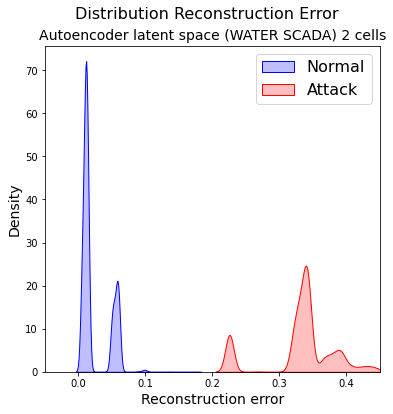

In [27]:
# === Paper Figure ===
# Distribución reconstruction error 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(
    Normal_error,
    fill    = True,
    ax      = ax,
    label   = 'Normal',
    color   = 'blue'
)
sns.kdeplot(
    Attack_error,
    fill    = True,
    ax      = ax,
    label   = 'Attack',
    color   = 'red'
)
#sns.rugplot(error_reconstruccion,  ax=ax, color='black')
plt.suptitle('Distribution Reconstruction Error',y=0.97, 
            fontsize=16)
ax.set_title('Autoencoder latent space (WATER SCADA) '+str(latent_space)+' cells', 
             fontsize=14)
ax.set_xlabel('Reconstruction error', fontsize = 14);
ax.set_ylabel('Density',fontsize=14);
ax.set_xlim(-0.05,0.45)
plt.legend( fontsize=16)
plt.savefig(path_figures+'Autoencoder_'+str(latent_space)+'_rea_wat.png', dpi=600)
plt.show()

In [28]:
#=================================================

In [29]:
#EOF